# Analyze and Predict Cryptocurrency Market

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
import yfinance as yf
import requests
from fredapi import Fred
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import pickle
import json
plt.style.use("seaborn-v0_8")

In [2]:
def read_api_key(file_path):
    with open(file_path, 'r') as file:
        api_key = file.readline().strip()  # Reading the first line and stripping any whitespace
    return api_key

# Get fred api key
file_path = './data/fred-api-key.txt'
fred_api_key = read_api_key(file_path)

In [3]:
current_crypto_market_sub_phase = "Bull"

In [4]:
import pandas as pd
import yfinance as yf
import datetime as dt

# Load historic CSV data
dfh = pd.read_csv("BTC-USD-20100722-20140916.csv", index_col=0, parse_dates=True)

# Get start date as day after last available date in historic data
start_date = dfh.index.max() + pd.Timedelta(days=1)
end_date = dt.date.today()
symbols = ["BTC-USD"]

# Download new data from Yahoo Finance
dfn = yf.download(symbols, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]

# Flatten MultiIndex columns from yfinance
dfn.columns = dfn.columns.get_level_values(0)

# Concatenate old and new data vertically
df = pd.concat([dfh, dfn])

# Save combined data to CSV
df.to_csv('./data/bitcoin-day-ohlcv.csv', index=True)

df  # Show combined dataframe

C:\Users\Enrico\AppData\Local\Temp\ipykernel_19852\3942806603.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfn = yf.download(symbols, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed


Open           High            Low          Close  \
Date                                                                     
2010-07-18       0.000000       0.100000       0.100000       0.100000   
2010-07-19       0.100000       0.100000       0.100000       0.100000   
2010-07-20       0.100000       0.100000       0.100000       0.100000   
2010-07-21       0.100000       0.100000       0.100000       0.100000   
2010-07-22       0.100000       0.100000       0.100000       0.100000   
...                   ...            ...            ...            ...   
2025-06-28  107090.546875  107567.882812  106883.976562  107327.703125   
2025-06-29  107327.820312  108526.304688  107230.109375  108385.570312   
2025-06-30  108383.437500  108798.789062  106759.648438  107135.335938   
2025-07-01  107144.382812  107550.679688  105270.226562  105698.281250   
2025-07-02  105703.101562  109763.656250  105157.398438  108859.320312   

                  Volume  
Date                      
2010-07-18           NaN  
2010-07-19           NaN  
2010-07-20           NaN  
2010-07-21           NaN  
2010-07-22           NaN  
...                  ...  
2025-06-28  3.003771e+10  
2025-06-29  3.553487e+10  
2025-06-30  4.206480e+10  
2025-07-01  4.411069e+10  
2025-07-02  5.624866e+10  

[5464 rows x 5 columns]

In [5]:
# Step 1: Fetch the top 10 cryptocurrencies by market capitalization from CoinGecko
def get_top_10_crypto_tickers():
    url = 'https://api.coingecko.com/api/v3/coins/markets'
    params = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': 10,
        'page': 1,
        'sparkline': 'false'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Extract the ticker symbols
    tickers = [coin['symbol'].upper() + '-USD' for coin in data]
    return tickers

# Get the top 10 crypto tickers
top_10_crypto_tickers = get_top_10_crypto_tickers()

my_crypto_portfolio_tickers = ["ETH-USD", "SHIB-USD", "THETA-USD", "MATIC-USD", "GALA-USD", "DOGE-USD", 
                  "AXS-USD", "ALGO-USD", "BNB-USD", "ZRX-USD", "FET-USD", "TRX-USD", "ADA-USD",
                 "SOL-USD", "BONK-USD", "AGIX-USD", "IMX-USD", "WIF-USD"]

# Combine the top 10 crypto tickers and your portfolio tickers
combined_tickers = top_10_crypto_tickers[1:9] + my_crypto_portfolio_tickers

# Use a set to remove duplicates and convert it back to a list
key_alt_crypto_tickers = list(set(combined_tickers))

start_date = "2001-01-01"
end_date = dt.date.today()
symbols = key_alt_crypto_tickers
dfas = yf.download(symbols, start_date, end_date)["Close"]

# Initialize the scaler
scaler = MinMaxScaler()

# Apply the scaler to the DataFrame
dfas[dfas.columns] = scaler.fit_transform(dfas[dfas.columns]) 

dfas

C:\Users\Enrico\AppData\Local\Temp\ipykernel_19852\997387086.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfas = yf.download(symbols, start_date, end_date)["Close"]
[*********************100%***********************]  21 of 21 completed


Ticker       ADA-USD  AGIX-USD  ALGO-USD   AXS-USD   BNB-USD  BONK-USD  \
Date                                                                     
2017-11-09  0.002748       NaN       NaN       NaN  0.000642       NaN   
2017-11-10  0.001073       NaN       NaN       NaN  0.000383       NaN   
2017-11-11  0.001181       NaN       NaN       NaN  0.000214       NaN   
2017-11-12  0.000005       NaN       NaN       NaN  0.000012       NaN   
2017-11-13  0.000627       NaN       NaN       NaN  0.000235       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-06-28  0.183996  0.190199  0.028246  0.012958  0.864413  0.277778   
2025-06-29  0.188204  0.196910  0.031292  0.013753  0.872808  0.277778   
2025-06-30  0.186178  0.191175  0.031135  0.013257  0.875465  0.277778   
2025-07-01  0.176001  0.183950  0.026540  0.012438  0.861271  0.259259   
2025-07-02  0.190247  0.199039  0.029763  0.013637  0.879514  0.296296   

Ticker      DOGE-USD   ETH-USD   FET-USD  GALA-USD  ...  MATIC-USD  SHIB-USD  \
Date                                                ...                        
2017-11-09  0.000551  0.050040       NaN       NaN  ...        NaN       NaN   
2017-11-10  0.000183  0.045464       NaN       NaN  ...        NaN       NaN   
2017-11-11  0.000238  0.048727       NaN       NaN  ...        NaN       NaN   
2017-11-12  0.000000  0.047295       NaN       NaN  ...        NaN       NaN   
2017-11-13  0.000253  0.049158       NaN       NaN  ...        NaN       NaN   
...              ...       ...       ...       ...  ...        ...       ...   
2025-06-28  0.237889  0.497655  0.207746  0.019366  ...        NaN    0.1500   
2025-06-29  0.246533  0.511160  0.215899  0.020774  ...        NaN    0.1500   
2025-06-30  0.240001  0.508094  0.205058  0.019649  ...        NaN    0.1375   
2025-07-01  0.229200  0.491031  0.201862  0.018528  ...        NaN    0.1375   
2025-07-02  0.245243  0.526046  0.216021  0.020388  ...        NaN    0.1500   

Ticker       SOL-USD  THETA-USD   TRX-USD  USDC-USD  USDT-USD   WIF-USD  \
Date                                                                      
2017-11-09       NaN        NaN  0.001322       NaN  0.373404       NaN   
2017-11-10       NaN        NaN  0.000542       NaN  0.353897       NaN   
2017-11-11       NaN        NaN  0.000519       NaN  0.380687       NaN   
2017-11-12       NaN        NaN  0.000000       NaN  0.411971       NaN   
2017-11-13       NaN        NaN  0.000776       NaN  0.383922       NaN   
...              ...        ...       ...       ...       ...       ...   
2025-06-28  0.575128   0.044341  0.643388  0.402003  0.302106  0.164970   
2025-06-29  0.584791   0.046876  0.648477  0.402490  0.302303  0.174144   
2025-06-30  0.590080   0.045679  0.655267  0.404505  0.302124  0.172391   
2025-07-01  0.560202   0.042858  0.653140  0.402436  0.301404  0.154435   
2025-07-02  0.580485   0.047328  0.666570  0.401881  0.303724  0.182331   

Ticker       XRP-USD   ZRX-USD  
Date                            
2017-11-09  0.024042  0.041669  
2017-11-10  0.020644  0.026722  
2017-11-11  0.021863  0.026696  
2017-11-12  0.017820  0.022542  
2017-11-13  0.019705  0.026556  
...              ...       ...  
2025-06-28  0.631964  0.036359  
2025-06-29  0.638458  0.039525  
2025-06-30  0.648240  0.036135  
2025-07-01  0.627687  0.031769  
2025-07-02  0.646702  0.038984  

[2793 rows x 21 columns]

In [6]:
# Download market data
mkt_tickers = ["SPY", "SWDA.L", "^IRX"]
df_mkt = yf.download(mkt_tickers, start=start_date, end=end_date)["Close"]

# Fetch Money Supply from FRED
fred = Fred(api_key=fred_api_key)
money_supply_series = 'M2SL'
money_supply_data = fred.get_series(money_supply_series, start_date, end_date)
money_supply_df = pd.DataFrame(money_supply_data, columns=['M2SL'])
daily_money_supply_df = money_supply_df.resample('D').ffill()

# Align indices for market and money supply data
common_index = df_mkt.index.intersection(daily_money_supply_df.index)
df_mkt = df_mkt.loc[common_index]
daily_money_supply_df = daily_money_supply_df.loc[common_index]

# Add money supply data to market data
df_mkt[money_supply_series] = daily_money_supply_df['M2SL'].values

# Step 1: Wilshire 5000 data
wilshire_ticker = "^W5000"
wilshire_data = yf.download(wilshire_ticker, start=start_date, end=end_date)["Close"]
wilshire_data.name = "Wilshire"

# Step 2: GDP data
gdp_series = 'GDP'
gdp_data = fred.get_series(gdp_series, start_date, end_date)

# GDP is quarterly, so let's convert to a DataFrame with a proper datetime index and frequency
gdp_df = pd.DataFrame(gdp_data, columns=['GDP'])
gdp_df.index = pd.to_datetime(gdp_df.index)
# Forward fill GDP data to daily frequency for alignment
gdp_daily = gdp_df.resample('D').ffill()

# Align Wilshire data with GDP daily index
wilshire_daily = wilshire_data.resample('D').ffill()

# Align the two series by index intersection
common_index = wilshire_daily.index.intersection(gdp_daily.index)
wilshire_daily = wilshire_daily.loc[common_index]
gdp_daily = gdp_daily.loc[common_index]

# Calculate Buffett Indicator daily: Wilshire Market Cap / GDP
# Since GDP is quarterly, forward filled daily, division is element-wise by aligned dates
buffett_indicator_daily = wilshire_daily["^W5000"] / gdp_daily['GDP']

# Align with df_mkt
common_index = df_mkt.index.intersection(buffett_indicator_daily.index)
df_mkt = df_mkt.loc[common_index]
buffett_indicator_daily = buffett_indicator_daily.loc[common_index]

# Add Buffett Indicator column to df_mkt
df_mkt['Buffett'] = buffett_indicator_daily.values

# Normalize all columns with MinMaxScaler
scaler = MinMaxScaler()
df_mkt[df_mkt.columns] = scaler.fit_transform(df_mkt[df_mkt.columns])

df_mkt

C:\Users\Enrico\AppData\Local\Temp\ipykernel_19852\3890616862.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_mkt = yf.download(mkt_tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
C:\Users\Enrico\AppData\Local\Temp\ipykernel_19852\3890616862.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  wilshire_data = yf.download(wilshire_ticker, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


Ticker           SPY    SWDA.L      ^IRX      M2SL   Buffett
2001-01-02  0.058406       NaN  1.000000  0.000000  0.407426
2001-01-03  0.065583       NaN  0.974071  0.000000  0.444421
2001-01-04  0.063898       NaN  0.923941  0.000000  0.435067
2001-01-05  0.058841       NaN  0.877269  0.000000  0.413953
2001-01-08  0.060001       NaN  0.891098  0.000000  0.411780
...              ...       ...       ...       ...       ...
2024-12-24  0.991947  0.987014  0.744166  0.981636  0.980613
2024-12-26  0.992019       NaN  0.746759  0.981636  0.980849
2024-12-27  0.980619  0.983510  0.740363  0.981636  0.966386
2024-12-30  0.968390  0.978563  0.741055  0.981636  0.953089
2024-12-31  0.964536  0.981861  0.745549  0.981636  0.948129

[6122 rows x 5 columns]

In [7]:
halving = {
    "Date": {"Open": ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-04-20'],
             "High": [],
             "Low": [],
             "Open_to_Open": [],
             "Open_to_High": [],
             "Low_to_High": [],
             "High_to_Low": []},
    "Price": {"Open": [],
              "High": [],
              "Low": [],
              "Open_to_Open": [],
              "Open_to_High": [],
              "Low_to_High": [],
              "High_to_Low": []}
}
halving["Date"]["Open"] = pd.to_datetime(halving["Date"]["Open"])

# Calculate Highs and Lows
for i in range(len(halving["Date"]["Open"])):

    current_halving = halving["Date"]["Open"][i]
    if i == 3:
        next_halving = "2023-12-31"   
    elif i == 4:
        next_halving = "2028-12-31"    
    else:
        next_halving = halving["Date"]["Open"][i + 1]

    halving_df = df[current_halving:next_halving]    
    if i == 0:
        halving["Price"]["Open"].append(0.1) 
    else:
        halving["Price"]["Open"].append(halving_df.iloc[0]['Open']) 
    halving["Price"]["High"].append(halving_df['High'].max())
    halving["Date"]["High"].append(halving_df['High'].idxmax()) 
    
    high_to_next_df = df[halving["Date"]["High"][i]:next_halving]
    halving["Price"]["Low"].append(high_to_next_df['Low'].min())
    halving["Date"]["Low"].append(high_to_next_df['Low'].idxmin())

# Calculate deltas and ratios
for i in range(len(halving["Date"]["Open"])):

    halving["Date"]["Open_to_High"].append(halving["Date"]["High"][i] - halving["Date"]["Open"][i])
    halving["Date"]["High_to_Low"].append(halving["Date"]["Low"][i] - halving["Date"]["High"][i])
    halving["Price"]["High_to_Low"].append(halving["Price"]["Low"][i] / halving["Price"]["High"][i])
    halving["Price"]["Open_to_High"].append(halving["Price"]["High"][i] / halving["Price"]["Open"][i])
    if i == 0:
        halving["Price"]["Low_to_High"].append(halving["Price"]["High"][i] / halving["Price"]["Open"][i])
        halving["Date"]["Low_to_High"].append(halving["Date"]["High"][i] - halving["Date"]["Open"][i])
        halving["Date"]["Open_to_Open"].append(halving["Date"]["Open"][i] - halving["Date"]["Open"][i])
        halving["Price"]["Open_to_Open"].append(halving["Price"]["Open"][i] / halving["Price"]["Open"][i])
    else:
        halving["Price"]["Low_to_High"].append(halving["Price"]["High"][i] / halving["Price"]["Low"][i-1])
        halving["Date"]["Low_to_High"].append(halving["Date"]["High"][i] - halving["Date"]["Low"][i-1])
        halving["Date"]["Open_to_Open"].append(halving["Date"]["Open"][i] - halving["Date"]["Open"][i-1])
        halving["Price"]["Open_to_Open"].append(halving["Price"]["Open"][i] / halving["Price"]["Open"][i-1])

# Create multi-index df
date_df = pd.DataFrame(halving["Date"])
price_df = pd.DataFrame(halving["Price"])
halving_dfs = [date_df.transpose(), price_df.transpose()]
halving_df = pd.concat(dict(enumerate(halving_dfs, start=1)), names=['Type', 'Indicator'])
halving_df = halving_df.rename(index={1: 'Date', 2: 'Price'}, level='Type')

halving_df.to_csv('./data/bitcoin-halving.csv', index=True)

# Create df for visualization
nice_halving = copy.deepcopy(halving)

# Extract the date component and format prices
for key in ["Open", "High", "Low"]:
    nice_halving["Date"][key] = [pd.to_datetime(date).date() for date in nice_halving["Date"][key]]
    nice_halving["Price"][key] = [f"{x/1000:.1f}K$" if x >= 100 else f"{x:.1f}$" for x in halving["Price"][key]]
for key in ["Open_to_Open", "Open_to_High", "Low_to_High", "High_to_Low"]:
    nice_halving["Date"][key] = [date.days for date in halving["Date"][key]]
    nice_halving["Date"][key] = [f"{x}d" for x in nice_halving["Date"][key]]
    if key == "High_to_Low": 
        nice_halving["Price"]["High_to_Low"] = [f"{round(x,2)}x" for x in nice_halving["Price"]["High_to_Low"]]
    else:
        nice_halving["Price"][key] = [f"{int(x)}x" for x in nice_halving["Price"][key]]
        
# Create multi-index df
nice_halving_dfs = [pd.DataFrame(nice_halving["Date"]).transpose(), pd.DataFrame(nice_halving["Price"]).transpose()]
nice_halving_df = pd.concat(dict(enumerate(nice_halving_dfs, start=1)), names=['Type', 'Indicator'])
nice_halving_df = nice_halving_df.rename(index={1: 'Date', 2: 'Price'}, level='Type')
nice_halving_df

0           1           2           3           4
Type  Indicator                                                               
Date  Open          2009-01-03  2012-11-28  2016-07-09  2020-05-11  2024-04-20
      High          2011-06-08  2013-11-29  2017-12-17  2021-11-10  2025-05-22
      Low           2011-10-19  2014-02-21  2018-12-15  2022-11-21  2025-06-22
      Open_to_Open          0d       1425d       1319d       1402d       1440d
      Open_to_High        886d        366d        526d        548d        397d
      Low_to_High         886d        772d       1395d       1061d        913d
      High_to_Low         133d         84d        363d        376d         31d
Price Open                0.1$       12.2$       0.7K$       8.8K$      63.9K$
      High               31.9$       1.2K$      20.1K$      68.8K$     112.0K$
      Low                 2.0$       91.7$       3.2K$      15.6K$      98.3K$
      Open_to_Open          1x        121x         54x         13x          7x
      Open_to_High        318x        101x         30x          7x          1x
      Low_to_High         318x        620x        219x         21x          7x
      High_to_Low        0.06x       0.07x       0.16x       0.23x       0.88x

In [8]:
halving_df

0                    1  \
Type  Indicator                                                
Date  Open          2009-01-03 00:00:00  2012-11-28 00:00:00   
      High          2011-06-08 00:00:00  2013-11-29 00:00:00   
      Low           2011-10-19 00:00:00  2014-02-21 00:00:00   
      Open_to_Open      0 days 00:00:00   1425 days 00:00:00   
      Open_to_High    886 days 00:00:00    366 days 00:00:00   
      Low_to_High     886 days 00:00:00    772 days 00:00:00   
      High_to_Low     133 days 00:00:00     84 days 00:00:00   
Price Open                          0.1                 12.2   
      High                         31.9               1241.9   
      Low                           2.0                 91.7   
      Open_to_Open                  1.0                122.0   
      Open_to_High                319.0           101.795082   
      Low_to_High                 319.0               620.95   
      High_to_Low              0.062696             0.073838   

                                      2                    3  \
Type  Indicator                                                
Date  Open          2016-07-09 00:00:00  2020-05-11 00:00:00   
      High          2017-12-17 00:00:00  2021-11-10 00:00:00   
      Low           2018-12-15 00:00:00  2022-11-21 00:00:00   
      Open_to_Open   1319 days 00:00:00   1402 days 00:00:00   
      Open_to_High    526 days 00:00:00    548 days 00:00:00   
      Low_to_High    1395 days 00:00:00   1061 days 00:00:00   
      High_to_Low     363 days 00:00:00    376 days 00:00:00   
Price Open                   666.383972          8755.535156   
      High                      20089.0            68789.625   
      Low                   3191.303467         15599.046875   
      Open_to_Open            54.621637            13.138874   
      Open_to_High            30.146283             7.856701   
      Low_to_High            219.073064            21.555338   
      High_to_Low              0.158858             0.226765   

                                      4  
Type  Indicator                          
Date  Open          2024-04-20 00:00:00  
      High          2025-05-22 00:00:00  
      Low           2025-06-22 00:00:00  
      Open_to_Open   1440 days 00:00:00  
      Open_to_High    397 days 00:00:00  
      Low_to_High     913 days 00:00:00  
      High_to_Low      31 days 00:00:00  
Price Open                 63851.101562  
      High                111970.171875  
      Low                  98286.203125  
      Open_to_Open             7.292655  
      Open_to_High             1.753614  
      Low_to_High              7.178014  
      High_to_Low              0.877789

In [9]:
# TO FIXXXX: for Bull case (see viz block), ok. check for halving and bear cases
# Change Phase dictionary as follow: Period: Number:1,2,3,4, Sub_Phase:Bull, Bear, Halving . BUT pay attention to how it is used in viz

last_halving = halving_df.iloc[:, -1]
second_last_halving = halving_df.iloc[:, -2]
last_date =  df.index.max() #pd.to_datetime("2022-12-01")
last_price = np.mean([df.Open.loc[last_date], df.High.loc[last_date], df.Low.loc[last_date], df.Close.loc[last_date]])
status = {
    "Date": {"Last": last_date,
             "Since_Open": last_date - last_halving.loc[("Date", "Open")],
             "Since_High": last_date - last_halving.loc[("Date", "High")],
             "Since_Low": last_date - second_last_halving.loc[("Date", "Low")],
            },
    "Price": {"Last": last_price,
              "Since_Open":  last_price / last_halving.loc[("Price", "Open")],
              "Since_High": last_price / last_halving.loc[("Price", "High")],
              "Since_Low": last_price / second_last_halving.loc[("Price", "Low")]
             },
    "Period": {"Count": halving_df.columns[-1],
               "Sub_Phase": current_crypto_market_sub_phase
              }
}
nice_status = copy.deepcopy(status)
nice_status["Date"]["Last"] = status["Date"]["Last"].strftime('%Y-%m-%d')
nice_status["Price"]['Last'] = f"{status['Price']['Last']/1000:.1f}K$" if status['Price']['Last'] >= 100 else f"{status['Price']['Last']:.1f}$"
for key in ['Since_Open', 'Since_High', 'Since_Low']:
    nice_status["Date"][key] = str(status['Date'][key].days) + "d"
    nice_status["Date"][key] = str(nice_status["Date"][key])
    if status["Price"][key] >= 1:
        rounded_value = round(status["Price"][key],1)  # Round to the nearest integer
    else:
        rounded_value = round(status["Price"][key], 2)  # Round to two decimal places
    nice_status["Price"][key] = f"{rounded_value}x"
nice_status

{'Date': {'Last': '2025-07-02',
  'Since_Open': '438d',
  'Since_High': '41d',
  'Since_Low': '954d'},
 'Price': {'Last': '107.4K$',
  'Since_Open': '1.7x',
  'Since_High': '0.96x',
  'Since_Low': '6.9x'},
 'Period': {'Count': 4, 'Sub_Phase': 'Bull'}}

In [10]:
# Multi Panel Plotly
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.02, row_heights=[0.4, 0.1, 0.1, 0.3])

# Add candlestick chart
fig.add_trace(go.Candlestick(x=df.index,
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'], 
                             name='Bitcoin',
                             showlegend=False), 
              row=1, col=1) 

# Add y-axis name "Price" to the first y-axis
fig.update_yaxes(row=1, col=1, 
                 fixedrange=False,
                 title_text="Price USD",
                 title_font=dict(size=12),
                 title_standoff = 10) 

# Determine color for volume bars based on relative change
df['Relative'] = df['Close'] - df['Open']
volume_colors = ["green" if relative >= 0 else "red" for relative in df['Relative']]

# Add volume bar chart
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], 
                     name='Volume', 
                     marker_color=volume_colors, 
                     marker_line_color='dimgray', 
                     marker_line_width=.001,
                     showlegend=False), 
              row=2, col=1)

# Set the yaxis for the volume subplot to log scale
fig.update_yaxes(row=2, col=1, 
                 type="log",
                 title_text="Volume",
                 title_font=dict(size=12),
                 title_standoff = 10
                 #range=[9,11.5]
                )  # log10(10,000)=4...

# Add line plot for the altcoins
for column in dfas.columns:
    fig.add_trace(go.Scatter(x=dfas.index, 
                             y=dfas[column], 
                             mode='lines', 
                             name=column, 
                             showlegend=False),
                  row=3, col=1)
# Update y-axis name for the altcoins
fig.update_yaxes(row=3, col=1,
                 title_text="Price USD",
                 title_font=dict(size=12),
                 title_standoff = 23)

# Add line plot for the market
for column in df_mkt.columns:
    fig.add_trace(go.Scatter(x=df_mkt.index, 
                             y=df_mkt[column], 
                             mode='lines', 
                             name=column,
                             showlegend=False),
                  row=4, col=1)
# Update y-axis name for the market
fig.update_yaxes(row=4, col=1,
                 title_text="Market",
                 title_font=dict(size=12),
                 title_standoff=23)

# Update layout
fig.update_layout(height=900, width=1200, title='BTC-USD Candlesticks with Volume Bars and Alt-Coins Lines',
                  xaxis_rangeslider_visible=False,
                  updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    buttons=[dict(label='Reset',
                                                  method='relayout', 
                                                  args=[{'xaxis.autorange': True, 
                                                         'yaxis.autorange': True,
                                                         'xaxis2.autorange': True, 
                                                         'yaxis2.autorange': True,
                                                         'xaxis3.autorange': True, 
                                                         'yaxis3.autorange': True,
                                                         'xaxis4.autorange': True, 
                                                         'yaxis4.autorange': True},  
                                                        [0, 1]])])])

# Add vertical lines and annotations
colors = ["black", "green", "red"]
line_types = ["solid", "dot", "dot"]
line_names = ["Open", "High", "Low"]

for color, line_type, line_name in zip(colors, line_types, line_names):
    dates_list = nice_halving_df.loc['Date', line_name]
    for i, date in enumerate(dates_list):
        open_low_to_high = nice_halving_df.loc['Date', 'Open_to_High'][i] + ", " + nice_halving_df.loc['Date', 'Low_to_High'][i]
        high_to_low = nice_halving_df.loc['Date', 'High_to_Low'][i]
        open_to_open = nice_halving_df.loc['Date', 'Open_to_Open'][i]


        fig.add_vline(x=date, line_width=1, line_dash=line_type, line_color=color)

        if line_name == "Open" and i > 0 and i <= nice_status["Period"]["Count"]:
            fig.add_annotation(
                    x=date,
                    y=fig['layout']['yaxis']['domain'][1] * 0.97,
                    text=open_to_open,
                    showarrow=False,
                    font=dict(color=color,size=9),
                    xanchor="right",
                    xshift=+1,
                    yshift=-5,
                    textangle=0)

        # Annotation for 'half_to_highs'
        if line_name == "High" and i != nice_status["Period"]["Count"]:
            fig.add_annotation(
                x=date,
                y=fig['layout']['yaxis']['domain'][1] * 0.97,
                text=open_low_to_high,
                showarrow=False,
                font=dict(color=color,size=9),
                xanchor="right",
                xshift=+1,
                yshift=-5,
                textangle=0)

        # Annotation for 'high_to_lows'
        if line_name == "Low" and i != nice_status["Period"]["Count"]:
            fig.add_annotation(
                x=date,
                y=fig['layout']['yaxis']['domain'][1] * 0.97,
                text=high_to_low,
                showarrow=False,
                font=dict(color=color,size=9),
                xanchor="right",
                xshift=+1,
                yshift=-5,
                textangle=0)

# Add annotations for Price High and Price Low
for i, (high_date, low_date) in enumerate(zip(nice_halving_df.loc['Date', 'High'], nice_halving_df.loc['Date', 'Low'])):
    high_price = halving_df.loc['Price', 'High'][i]
    low_price = halving_df.loc['Price', 'Low'][i]
    nice_high_price = nice_halving_df.loc['Price', 'High'][i]
    nice_low_price = nice_halving_df.loc['Price', 'Low'][i]
    nice_low_to_high_price = nice_halving_df.loc['Price', 'Low_to_High'][i]
    nice_high_to_low_price = nice_halving_df.loc['Price', 'High_to_Low'][i]
    high_text = nice_high_price+" ("+nice_low_to_high_price+")"
    low_text = nice_low_price+" ("+nice_high_to_low_price+")"

    # Annotation for Price High
    fig.add_annotation(
        x=high_date,
        y=high_price,
        text=high_text,
        showarrow=True,
        arrowhead=2,
        arrowcolor="green",
        arrowsize=1,
        arrowwidth=2,
        ax=10,
        ay=-33,
        font=dict(color="green", size=12),
        xshift=5,
    )

    # Annotation for Price Low
    fig.add_annotation(
        x=low_date,
        y=low_price,
        text=low_text,
        showarrow=True,
        arrowhead=2,
        arrowcolor="red",
        arrowsize=1,
        arrowwidth=2,
        ax=10,
        ay=33,
        font=dict(color="red", size=12),
        xshift=5,
    )

# Add status
colors = ["black", "green", "red", "blue"]
timedelta_texts = ["", "", "", ""]
yshifts = [-15,-24,-33,-42]
if nice_status["Period"]["Sub_Phase"] == "Bull":
    timedelta_texts[1] = nice_status['Date']['Since_Open']  + ", " + nice_status['Date']['Since_Low']
    timedelta_texts[2] = nice_status["Period"]["Sub_Phase"]
    colors[2] = "green"
elif nice_status["Period"]["Sub_Phase"] == "Bear":
    timedelta_texts[1] = nice_status['Date']['Since_High']
    timedelta_texts[2] = nice_status["Period"]["Sub_Phase"]
    colors[2] = "red"
elif nice_status["Period"]["Sub_Phase"] == "Halving":  
    timedelta_texts[0] = nice_status['Date']['Since_Open']
    timedelta_texts[1] = "-d, " + nice_status['Date']['Since_Low']
    timedelta_texts[2] = nice_status["Period"]["Sub_Phase"]
    colors[2] = "black"
else:  
    timedelta_texts[0] = nice_status['Date']['Since_Open']
    timedelta_texts[1] = nice_status['Date']['Since_Open']  + ", " + nice_status['Date']['Since_Low']
    timedelta_texts[2] = nice_status['Date']['Since_High']
    timedelta_texts[3] = nice_status["Period"]["Sub_Phase"]

for timedelta_text, yshift, color in zip(timedelta_texts, yshifts, colors):
    fig.add_annotation(
        x=status["Date"]["Last"],
        y=fig['layout']['yaxis']['domain'][1] * 0.97,  
        text=timedelta_text,
        showarrow=False,
        font=dict(color=color,size=9),
        xanchor="right",
        xshift=+40,
        yshift=yshift,
        textangle=0)

# Add halving period number
for i in range(1,halving_df.shape[1]):
    fig.add_annotation(
        x=halving_df.loc['Date', 'Open'][i],
        y=df.High.max() * 1.05, 
        text=str(i) + "' Halving",
        showarrow=False,
        font=dict(color="black",size=9),
        xanchor="right",
        xshift=+1,
        textangle=0)

# Show the plot
fig.show()

## Power Law

### Log Transformation

In [11]:
# Define the start date (Genesis Block date: January 3, 2009)
genesis_date = pd.Timestamp('2009-01-03')

# Create a 'days since genesis block' column
df['days_since_genesis'] = (df.index - genesis_date).days

# Log-transform the 'Close' price and 'days since genesis'
df['log_price'] = np.log10(df['Close'])
df['log_days_since_genesis'] = np.log10(df['days_since_genesis'])

df.to_csv('./data/bitcoin-day-master.csv', index=True)
df

Open           High            Low          Close  \
Date                                                                     
2010-07-18       0.000000       0.100000       0.100000       0.100000   
2010-07-19       0.100000       0.100000       0.100000       0.100000   
2010-07-20       0.100000       0.100000       0.100000       0.100000   
2010-07-21       0.100000       0.100000       0.100000       0.100000   
2010-07-22       0.100000       0.100000       0.100000       0.100000   
...                   ...            ...            ...            ...   
2025-06-28  107090.546875  107567.882812  106883.976562  107327.703125   
2025-06-29  107327.820312  108526.304688  107230.109375  108385.570312   
2025-06-30  108383.437500  108798.789062  106759.648438  107135.335938   
2025-07-01  107144.382812  107550.679688  105270.226562  105698.281250   
2025-07-02  105703.101562  109763.656250  105157.398438  108859.320312   

                  Volume     Relative  days_since_genesis  log_price  \
Date                                                                   
2010-07-18           NaN     0.100000                 561  -1.000000   
2010-07-19           NaN     0.000000                 562  -1.000000   
2010-07-20           NaN     0.000000                 563  -1.000000   
2010-07-21           NaN     0.000000                 564  -1.000000   
2010-07-22           NaN     0.000000                 565  -1.000000   
...                  ...          ...                 ...        ...   
2025-06-28  3.003771e+10   237.156250                6020   5.030712   
2025-06-29  3.553487e+10  1057.750000                6021   5.034971   
2025-06-30  4.206480e+10 -1248.101562                6022   5.029933   
2025-07-01  4.411069e+10 -1446.101562                6023   5.024068   
2025-07-02  5.624866e+10  3156.218750                6024   5.036866   

            log_days_since_genesis  
Date                                
2010-07-18                2.748963  
2010-07-19                2.749736  
2010-07-20                2.750508  
2010-07-21                2.751279  
2010-07-22                2.752048  
...                            ...  
2025-06-28                3.779596  
2025-06-29                3.779669  
2025-06-30                3.779741  
2025-07-01                3.779813  
2025-07-02                3.779885  

[5464 rows x 9 columns]

### Linear regressions

In [12]:
# Perform linear regression on log-transformed data
X = df['log_days_since_genesis'].values.reshape(-1, 1)  # Log of days since genesis (independent variable)
y = df['log_price'].values  # Log of Close price (dependent variable)

# Create the linear regression model
model = LinearRegression()

# Fit the model to the log-transformed data
model.fit(X, y)

# Save the model to a file
with open('./data/model-bitcoin-price-log-linreg.pkl', 'wb') as file:
    pickle.dump(model, file)

# Predict the log-transformed price values
y_pred = model.predict(X)

# Calculate R-squared and Mean Squared Error for the model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print the R-squared, Mean Squared Error, intercept and slope (inclination)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

R-squared: 0.9593393589897654
Mean Squared Error: 0.0931440336006558
Intercept: -16.441459743226652
Slope: 5.672111743511903


In [13]:
date_highs = halving_df.loc['Date', 'High'].apply(lambda x: x.date())
df_highs = df.loc[date_highs[:4]]
df_highs
df_highs.to_csv('./data/bitcoin-day-highs.csv', index=True)

# Perform linear regression on log-transformed data
X = df_highs['log_days_since_genesis'].values.reshape(-1, 1)  # Log of days since genesis (independent variable)
y = df_highs['log_price'].values  # Log of Close price (dependent variable)

# Create the linear regression model
model_highs = LinearRegression()

# Fit the model to the log-transformed data
model_highs.fit(X, y)

# Save the model to a file
with open('./data/model-bitcoin-highs-log-linreg.pkl', 'wb') as file:
    pickle.dump(model_highs, file)

# Predict the log-transformed price values
y_pred_highs = model_highs.predict(X)

# Calculate R-squared and Mean Squared Error for the model
r2 = r2_score(y, y_pred_highs)
mse = mean_squared_error(y, y_pred_highs)

y_highs_line = model_highs.coef_[0] * df['log_days_since_genesis'].values + model_highs.intercept_

# Print the R-squared, Mean Squared Error, intercept and slope (inclination)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Intercept: {model_highs.intercept_}")
print(f"Slope: {model_highs.coef_[0]}")

R-squared: 0.9942259076660853
Mean Squared Error: 0.009519695848716814
Intercept: -12.185092567232626
Slope: 4.66048742547617


In [14]:
date_lows = halving_df.loc['Date', 'Low'].apply(lambda x: x.date())
df_lows = df.loc[date_lows[:4]]
df_lows
df_lows.to_csv('./data/bitcoin-day-lows.csv', index=True)

# Perform linear regression on log-transformed data
X = df_lows['log_days_since_genesis'].values.reshape(-1, 1)  # Log of days since genesis (independent variable)
y = df_lows['log_price'].values  # Log of Close price (dependent variable)

# Create the linear regression model
model_lows = LinearRegression()

# Fit the model to the log-transformed data
model_lows.fit(X, y)

# Save the model to a file
with open('./data/model-bitcoin-lows-log-linreg.pkl', 'wb') as file:
    pickle.dump(model_lows, file)

# Predict the log-transformed price values
y_pred_lows = model_lows.predict(X)

# Calculate R-squared and Mean Squared Error for the model
r2 = r2_score(y, y_pred_lows)
mse = mean_squared_error(y, y_pred_lows)

y_lows_line = model_lows.coef_[0] * df['log_days_since_genesis'].values + model_lows.intercept_

# Print the R-squared, Mean Squared Error, intercept and slope (inclination)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Intercept: {model_lows.intercept_}")
print(f"Slope: {model_lows.coef_[0]}")

R-squared: 0.9959379094721614
Mean Squared Error: 0.008812621638017317
Intercept: -16.033801149071707
Slope: 5.481363847166391


### Original Log-Log chart

In [15]:
# Create the log-log plot using Plotly
fig = go.Figure()

# Add the actual log-transformed BTC price trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=df['log_price'],
    mode='lines',
    name='Log10 of BTC Price',
    line=dict(color='black')
))

# Add the fitted linear regression line trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_pred,
    mode='lines',
    name='Fitted Line (Linear Regression)',
    line=dict(color='blue')
))

# Add the upper band trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_highs_line,
    mode='lines',
    name='Highs line',
    line=dict(color='green', dash='dash')
))

# Add the lower band trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_lows_line,
    mode='lines',
    name='Lows Line',
    line=dict(color='red', dash='dash')
))

# Set the title and axis labels
fig.update_layout(
    title='Power Law Fit for Bitcoin Price with Linear Regression, Upper and Lower Bands',
    xaxis_title='Log10 Days from Jan 3, 2009 (Genesis Block)',
    yaxis_title='Log10 of BTC Price',
    showlegend=True,
    height=800  # Increase the height to make the y-axis taller
)

# Add grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()

### Modified Log-Log chart (x-axis labels)

In [16]:
# Prepare modified labels
# Create a new DataFrame to extract the first occurrence of each year
df_yearly = df.groupby(df.index.year).first()

# Define tick values and corresponding labels (only years, no duplicates)
tickvals_x = df_yearly['log_days_since_genesis'].values  # Use the first occurrence of each year
ticktext_x = df_yearly.index.astype(str)  # Extract the year as string for labeling

# Define custom y-axis ticks based on powers of 10
tickvals_y = np.arange(np.floor(df['log_price'].min()), np.ceil(df['log_price'].max()) + 1)  # Integer tick values for log_price

# Format the y-axis values to append 'K' for thousands, 'M' for millions without decimals
def format_ticks(val):
    if val >= 1_000_000:
        return f"{int(val / 1_000_000)}M"  # Divide by 1M and add 'M' without decimals
    elif val >= 1_000:
        return f"{int(val / 1_000)}K"  # Divide by 1K and add 'K' without decimals
    else:
        return f"{int(val)}"  # No division for values less than 1000

# Compute tick labels using the format_ticks function
ticktext_y = [format_ticks(10**int(i)) for i in tickvals_y]

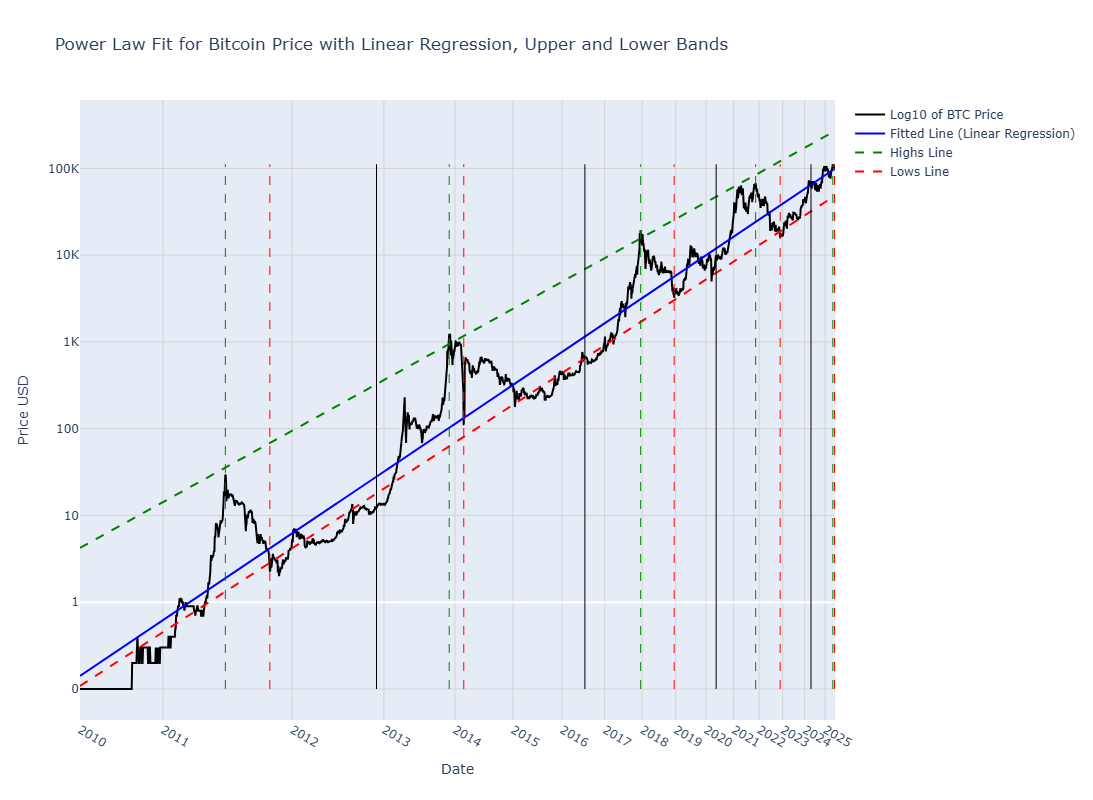

In [17]:
# Create the log-log plot using Plotly
fig = go.Figure()

# Add the actual log-transformed BTC price trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=df['log_price'],
    mode='lines',
    name='Log10 of BTC Price',
    line=dict(color='black')
))

# Add the fitted linear regression line trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_pred,
    mode='lines',
    name='Fitted Line (Linear Regression)',
    line=dict(color='blue')
))

# Add the upper band trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_highs_line,
    mode='lines',
    name='Highs Line',
    line=dict(color='green', dash='dash')
))

# Add the lower band trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_lows_line,
    mode='lines',
    name='Lows Line',
    line=dict(color='red', dash='dash')
))

# Extract 'Open', 'High', and 'Low' dates from the multi-index halving_df
halving_open_dates = halving_df.loc['Date', 'Open'].values
halving_high_dates = halving_df.loc['Date', 'High'].values
halving_low_dates = halving_df.loc['Date', 'Low'].values

# Add vertical black lines at halving events for 'Open' dates
for open_date in halving_open_dates:
    log_days = df.loc[df.index == open_date, 'log_days_since_genesis'].values
    if log_days.size > 0:
        fig.add_shape(
            type="line",
            x0=log_days[0],
            x1=log_days[0],
            y0=min(df['log_price']),
            y1=max(df['log_price']),
            line=dict(color="black", width=1),  # Black and continuous
            name=f'Halving on {open_date.date()}'
        )

# Add dashed green vertical lines for 'High' dates
for high_date in halving_high_dates:
    log_days = df.loc[df.index == high_date, 'log_days_since_genesis'].values
    if log_days.size > 0:
        fig.add_shape(
            type="line",
            x0=log_days[0],
            x1=log_days[0],
            y0=min(df['log_price']),
            y1=max(df['log_price']),
            line=dict(color="green", width=1, dash='dash'),  # Green dashed line
            name=f'Halving High on {high_date.date()}'
        )

# Add dashed red vertical lines for 'Low' dates
for low_date in halving_low_dates:
    log_days = df.loc[df.index == low_date, 'log_days_since_genesis'].values
    if log_days.size > 0:
        fig.add_shape(
            type="line",
            x0=log_days[0],
            x1=log_days[0],
            y0=min(df['log_price']),
            y1=max(df['log_price']),
            line=dict(color="red", width=1, dash='dash'),  # Red dashed line
            name=f'Halving Low on {low_date.date()}'
        )

# Set the title and axis labels
fig.update_layout(
    title='Power Law Fit for Bitcoin Price with Linear Regression, Upper and Lower Bands',
    xaxis_title='Date',
    yaxis_title='Price USD',
    showlegend=True,
    height=800,  # Adjusting the height to make y-axis taller
    xaxis=dict(
        tickvals=tickvals_x,  # Use log_days_since_genesis values for tick placement (first of each year)
        ticktext=ticktext_x,  # Use Year for the labels
        tickmode='array'
    ),
    yaxis=dict(
        tickvals=tickvals_y,  # Use integer tick values for log_price
        ticktext=ticktext_y,  # Format labels as per K/M notation without decimals
        tickmode='array'
    )
)

# Add grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Save the figure as a JSON file
with open('./data/plotly-bitcoin-log.json', 'w') as f:
    f.write(fig.to_json())
    
# Show the plot
fig.show()